In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline



# olist_customers.shape[0] - 99441
olist_customers_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
olist_customers = pd.read_csv(olist_customers_path, sep=',')



# olist_orders.shape[0] - 99441
olist_orders_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
olist_orders = pd.read_csv(olist_orders_path, sep=',')

olist_orders.order_purchase_timestamp = pd.to_datetime(olist_orders['order_purchase_timestamp'])
olist_orders.order_approved_at = pd.to_datetime(olist_orders['order_approved_at'])
olist_orders.order_delivered_carrier_date = pd.to_datetime(olist_orders['order_delivered_carrier_date'])
olist_orders.order_delivered_customer_date = pd.to_datetime(olist_orders['order_delivered_customer_date'])
olist_orders.order_estimated_delivery_date = pd.to_datetime(olist_orders['order_estimated_delivery_date'])



# olist_orders_items.shape[0] - 112650
olist_orders_items_path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'
olist_orders_items = pd.read_csv(olist_orders_items_path, sep=',')

olist_orders_items.shipping_limit_date = pd.to_datetime(olist_orders_items['shipping_limit_date'])

# Задание 5

**Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с 
самым высоким retention на 3й месяц.**

Нашей целью является retention, а именно возвращаемость пользователей в продукт, следовательно, нам нет необходимости отбирать только пользователей, совершивших покупки. Как целевое действие определим любое взаимодействие с продуктом, т.к. нам полезно, чтобы пользователи просматривали рекламу, рекомендации и т.д. внутри продукта. Также зная активность клиентов, например, что пользователь хотел совершить заказ, но его отменил или товар был недоступен, мы можем попробовать как-то влиять на пользователей. 

Таким образом, нас интересует сам факт возвращения, т.е. любой заказ будь то отмененный/недоступный и так далее. Учитывая, что каждый заказ имеет уникальный статус для себя (т.е. нет истории заказа, например, заказ с id = 1 имеет статусы "подтвержден" -> "отгружен со склада" -> "доставлен"), можем ссылаться на каждый заказ как на уникальное взаимодействие с продуктом.

Определим:
- Признак когорты - самая первая дата заказа для каждого пользователя
- Размер когорты - месяц
- Временной интервал - январь 2017 - март 2018 (март 2018 выбран для того, чтобы увидеть retention третьего месяца для каждого месяца 2017 года)

In [2]:
inc_list = ['customer_unique_id', 'order_purchase_timestamp']
merged5 = olist_customers.merge(olist_orders, how='inner', on='customer_id')\

merged5_1 = merged5.loc[(merged5.order_purchase_timestamp.dt.year == 2017) |
                        ((merged5.order_purchase_timestamp.dt.year == 2018) &
                        (merged5.order_purchase_timestamp.dt.month < 4))
                        , inc_list]



first_purchase = merged5_1.groupby('customer_unique_id', as_index=False)\
                          .agg({'order_purchase_timestamp':'min'})\
                          .rename(columns={'order_purchase_timestamp':'first_purchase_timestamp'})

first_purchase['month_year_first_purchase'] = first_purchase['first_purchase_timestamp'].dt.strftime('%Y/%m')
first_purchase.head()

,customer_unique_id,first_purchase_timestamp,month_year_first_purchase
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017/03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017/10
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017/11
3,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41,2018/02
4,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,2017/03


Рассчитаем "расстояние" от каждой даты каждого заказа до даты первого заказа:

In [3]:
final_task5 = merged5_1.merge(first_purchase, how='left', on='customer_unique_id')

final_task5['cohort_lifetime'] = 12 * (final_task5.order_purchase_timestamp.dt.year - 
                                       final_task5.first_purchase_timestamp.dt.year)\
                                    + (final_task5.order_purchase_timestamp.dt.month - 
                                       final_task5.first_purchase_timestamp.dt.month)

final_task5.head()

,customer_unique_id,order_purchase_timestamp,first_purchase_timestamp,month_year_first_purchase,cohort_lifetime
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05-16 15:05:35,2017/05,0
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01-12 20:48:24,2018/01,0
2,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03-13 16:06:38,2018/03,0
3,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:14:31,2017-09-14 18:14:31,2017/09,0
4,addec96d2e059c80c30fe6871d30d177,2018-02-19 14:38:35,2018-02-19 14:38:35,2018/02,0


Далее следует расчет когорт - числа пользователей, входящих в определенный год/месяц и жизненный цикл: 

In [4]:
cohorts = final_task5.pivot_table(index = ['month_year_first_purchase','cohort_lifetime'], 
                            aggfunc = {'customer_unique_id':'nunique'}).reset_index()

cohorts.head()

,month_year_first_purchase,cohort_lifetime,customer_unique_id
0,2017/01,0,765
1,2017/01,1,3
2,2017/01,2,2
3,2017/01,3,1
4,2017/01,4,3


Выберем из каждой когорты значения в нулевой месяц, т.е. размер каждой когорты год/месяц:

In [5]:
initial_users_count = cohorts[cohorts.cohort_lifetime == 0]
initial_users_count = initial_users_count[['month_year_first_purchase','customer_unique_id']]
initial_users_count = initial_users_count.rename(columns={'customer_unique_id':'cohort_users'}) 

initial_users_count.head()

,month_year_first_purchase,cohort_users
0,2017/01,765
14,2017/02,1752
28,2017/03,2636
41,2017/04,2353
53,2017/05,3596


Соединим значения когорт с их размером и расчитаем retention как их отношение:

In [6]:
final_task5_1 = cohorts.merge(initial_users_count, on='month_year_first_purchase')
final_task5_1['retention'] = final_task5_1.customer_unique_id/final_task5_1.cohort_users

final_task5_1.head()

,month_year_first_purchase,cohort_lifetime,customer_unique_id,cohort_users,retention
0,2017/01,0,765,765,1.000000
1,2017/01,1,3,765,0.003922
2,2017/01,2,2,765,0.002614
3,2017/01,3,1,765,0.001307
4,2017/01,4,3,765,0.003922


Исходя из полученных данных, **ответ на вопрос задачи - Июнь 2017:**

In [7]:
final_task5_1.iloc[final_task5_1.query("cohort_lifetime == 3").retention.idxmax(), 0]

'2017/06'

Можем также построить график для большей наглядности:

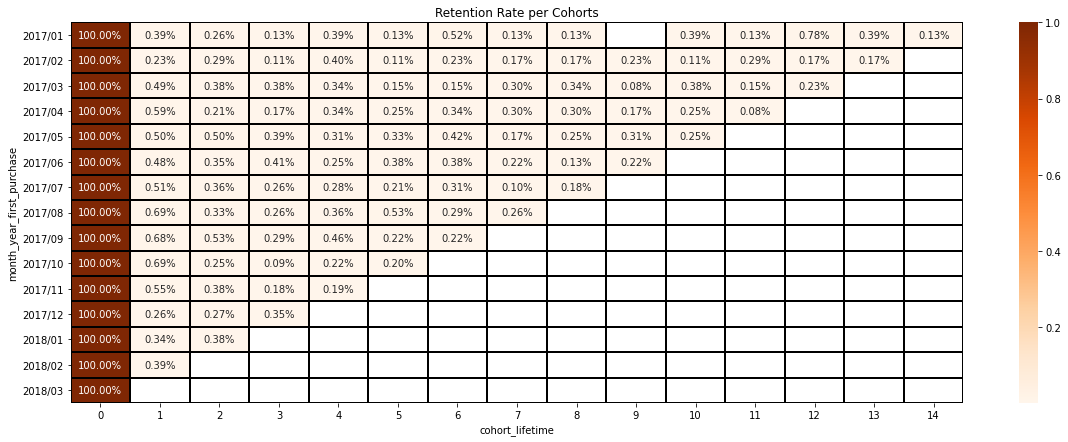

In [8]:
retention_pivot = final_task5_1.pivot_table(index='month_year_first_purchase',
                                            columns='cohort_lifetime',
                                            values='retention',
                                            aggfunc='sum')


plt.figure(figsize=(20, 7))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='black', cmap="Oranges")

**Вывод:** для retention характерно резкое падение активности, однако из полученного графика можем увидеть, что метрика показывает крайне низкие значения даже с учетом ее характерных значений. Такие низкие значения обеспечиваются тем, что бОльшая часть пользователей совершили всего 1 покупку и более не возвращались. Считаю, нам стоит работать над улучшением продукта, его ценности для пользователей, проводить исследования по поиску причин такого оттока и стараться приводить клиентов ко второй покупке. 

# Задание 6

**Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.**

В расчет берем только записи со статусом 'delivered', т.к. покупкой и полученной с нее прибылью можно считать оплаченные и доставленные клиенту заказы, остальные статусы - это либо отмененные и недоступные, либо какие-то промежуточные. 

Также в данных есть записи со статусом 'delivered' с пустой датой подтверждения оплаты или датой доставки клиенту. Возможно, это можно объяснить какой-то ошибкой в данных или в случае с пустой датой доставки клиенту можно предположить, что клиенту не смогли доставить заказ или он его не забрал из пункта выдачи (что нужно было бы проверить дополнительно). Учитывая это, все же удалим и эти записи из нашего анализа:

In [9]:
merged6_1 = olist_customers.merge(olist_orders, how='inner', on='customer_id')
merged6_2 = olist_orders_items.merge(merged6_1, how='left', on='order_id')

sales = merged6_2.query("order_status == 'delivered'")\
                 .loc[~((merged6_2.order_delivered_customer_date.isna()) | (merged6_2.order_approved_at.isna()))]

sales.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


В ходе работы выяснилось, что не для всех order_id существуют записи о составе корзины покупок. Если посмотреть на состав этих заказов по статусам, в основном это отмененные или недоступные. Предполагаю, по какой-то причине не удалось получить состав этих заказов (стоит также уточнить этот момент с соответствуюшей командой):

In [10]:
not_in_items = olist_orders[~olist_orders['order_id'].isin(olist_orders_items.order_id)]
orders_not_in = not_in_items[not_in_items.order_delivered_customer_date.isna()].order_id.to_list()

merged6_1.query("order_id in @orders_not_in").sort_values('customer_unique_id').order_status.value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

Продолжим анализ с имеющимися данными и рассчитаем сумму всех покупок по каждому заказу:

In [11]:
orders = sales.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False)\
              .agg({'price':'sum'})

orders.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90


Выберем для анализа данные за год (Ферваль 2017 - Ферваль 2018), также расчитаем наименьшую разницу между датой покупки и текущей (в нашем случае - 1 марта 2018), общее число покупок и общую сумму всех заказов для каждого пользователя:

In [12]:
period = 365
NOW = pd.to_datetime('2018-02-28 23:59:59')

orders['DaysSinceOrder'] = (NOW - orders['order_purchase_timestamp']).dt.days
orders.query("DaysSinceOrder <= @period and DaysSinceOrder >= 0", inplace=True)

rfm = orders.groupby('customer_unique_id', as_index=False)\
            .agg({'DaysSinceOrder':'min', 'order_id':'count', 'price':'sum'})\
            .rename(columns={'DaysSinceOrder': 'Recency', 'order_id': 'Frequency', 'price': 'Monetary'})

rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,355,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,139,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,106,1,180.00
3,00053a61a98854899e70ed204dd4bafe,0,1,382.00
4,0005e1862207bf6ccc02e4228effd9a0,361,1,135.00


Однако, исходя из особенностей наших данных, посмотрим подробнее. Только около 3% пользователей совершили больше 1 заказа. Сравним пользователей с 2+ заказами и с 1 заказом. Однако перед этим логарифмируем монетизацию, чтобы сгладить экремальные значения: 

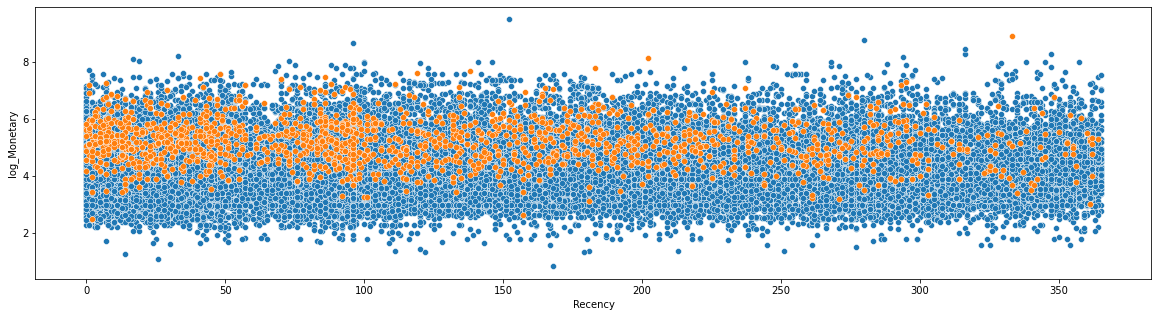

In [13]:
rfm['log_Monetary'] = np.log(rfm.Monetary)


plt.figure(figsize=(20, 5))
sns.scatterplot(data=rfm.query("Frequency == 1"), x='Recency', y='log_Monetary')
sns.scatterplot(data=rfm.query("Frequency > 1"), x='Recency', y='log_Monetary')

Видим, что не только монетизация 2+ пользователей выше (что логично, т.к. количество заказов у них больше), но и большАя часть пользователей совершили последний заказ не так давно. Таким образом, можно сказать, что с пользователями с 2+ заказами все хорошо, учитывая к тому же их возвращаемость к продукту. 

Предлагаю рассмотреть эти сегменты отдельно и начать с пользователей с 1 заказом, в этом случае мы переходим в двумерную плоскость, где не учитываем влияние F-фактора.

Разделение на ранги по последней активности (применимо к обоим сегментам - и 1, и 2+):
- 5 - 0-30 days (0 to 1 month)
- 4 - 31-60 days (1 to 2 month)
- 3 - 61-90 days (2 to 3 month)
- 2 - 91-180 days (3 to 6 month)
- 1 - 181-365 days (6 to 12 month)

Разделение на ранги по сумме по заказам составлено на основе квантилей:
- 0 to 50 (~0-25 quantile)
- 50 to 100 (~25-55 quantile)
- 100 to 150 (~55-75 quantile)
- 150+


In [14]:
def r_score(x):
    if x <= 30:
        return 5
    elif x <= 60:
        return 4
    elif x <= 90:
        return 3
    elif x <= 180:
        return 2
    else:
        return 1 

def m1_score(x):
    if x <= 50:
        return 1
    elif x <= 100:
        return 2
    elif x <= 150:
        return 3
    else:
        return 4

После применения функции получаем RM-оценку:

In [15]:
rfm1 = rfm.copy().query("Frequency == 1")

rfm1['R'] = rfm1['Recency'].apply(lambda x: r_score(x))
rfm1['M'] = rfm1['Monetary'].apply(lambda x: m1_score(x))

rfm1['RM'] = rfm1['R'].astype(str) + rfm1['M'].astype(str)
rfm1['RM_Score'] = rfm1[['R', 'M']].sum(axis=1)

rfm1.head()

,customer_unique_id,Recency,Frequency,Monetary,log_Monetary,R,M,RM,RM_Score
0,0000f46a3911fa3c0805444483337064,355,1,69.00,4.234107,1,2,12,3
1,0000f6ccb0745a6a4b88665a16c9f078,139,1,25.99,3.257712,2,1,21,3
2,0004aac84e0df4da2b147fca70cf8255,106,1,180.00,5.192957,2,4,24,6
3,00053a61a98854899e70ed204dd4bafe,0,1,382.00,5.945421,5,4,54,9
4,0005e1862207bf6ccc02e4228effd9a0,361,1,135.00,4.905275,1,3,13,4


Для дальнейшего анализа можно разбить на сегменты, например, так:

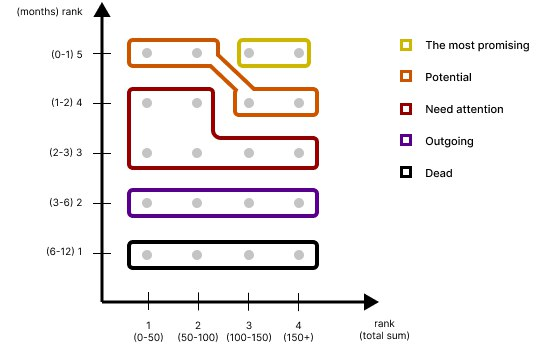

- **The most promising** - пользователи, платящие много и совершившие покупку недавно, скорее всего, имеют большой потенциал лояльности. *(+) - Из того, что это их первый заказ, а также из предположения, что нет данных больше, чем за год, следует, что это новые пользователи, которые недавно зарегистрировались. Следовательно, стоит плотно работать с такими пользователями. Нужно всеми силами пытаться удержать их в продукте и показать его ценность (возможно, скидками, акциями, реферальными программами).*

- **Potencial** - пользователи, которые потенциально могут стать лояльными, относительно недавно совершили покупку. К части из них применим пункт (+) аналогично с *The most promising*.

- **Need Attention** - самый многочисленный сегмент по покрытию плоскости. Необходимо тщательнее его изучить, возможно, можем как-то удержать/заинтересовать пользователей. Какую-то часть из них возможно удастся вернуть, например, рассылкой пушей.

- **Outgoing** - уходящие от нас пользователи, их скорее всего уже не получится вернуть, слишком давно сделана покупка + покупка всего одна и, вероятно, такие пользователи не нашли для себя ценность в продукте. Часть пользователей постеренно переходит в сегмент *Dead*.

- **Dead** - ушедшие пользователи, которые с очень большой вероятностью не вернутся к нам, т.к. не нашли ценность в продукте при первой и единственной покупке.

Реализуем функцию для такого разбиения и получим новые сегменты, применив ее:

In [16]:
def rfm_level1(df):
    if (df['M'] in [3, 4]) and (df['R'] == 5):
        return 'The most promising'
    elif ((df['M'] in [1, 2]) and (df['R'] == 5)) or ((df['M'] in [3, 4]) and (df['R'] == 4)):
        return 'Potencial'
    elif ((df['M'] in [1, 2]) and (df['R'] == 4)) or (df['R'] == 3):
        return 'Need Attention'
    elif df['R'] == 2:
        return 'Outgoing'
    else:
        return 'Dead'
    

rfm1['RM_Level'] = rfm1.apply(rfm_level1, axis=1)

rfm1.head()

,customer_unique_id,Recency,Frequency,Monetary,log_Monetary,R,M,RM,RM_Score,RM_Level
0,0000f46a3911fa3c0805444483337064,355,1,69.00,4.234107,1,2,12,3,Dead
1,0000f6ccb0745a6a4b88665a16c9f078,139,1,25.99,3.257712,2,1,21,3,Outgoing
2,0004aac84e0df4da2b147fca70cf8255,106,1,180.00,5.192957,2,4,24,6,Outgoing
3,00053a61a98854899e70ed204dd4bafe,0,1,382.00,5.945421,5,4,54,9,The most promising
4,0005e1862207bf6ccc02e4228effd9a0,361,1,135.00,4.905275,1,3,13,4,Dead


Построим визуализацию получившихся сегментов:

In [17]:
names1 = rfm1.RM_Level.value_counts().to_frame().index.to_list()
df1 = rfm1.RM_Level.value_counts().to_frame().reset_index()

# uncomment to find the details
# fig = px.treemap(df1, path=[names1], values='RM_Level', color='RM_Level', color_continuous_scale = 'oranges')
# fig.show()

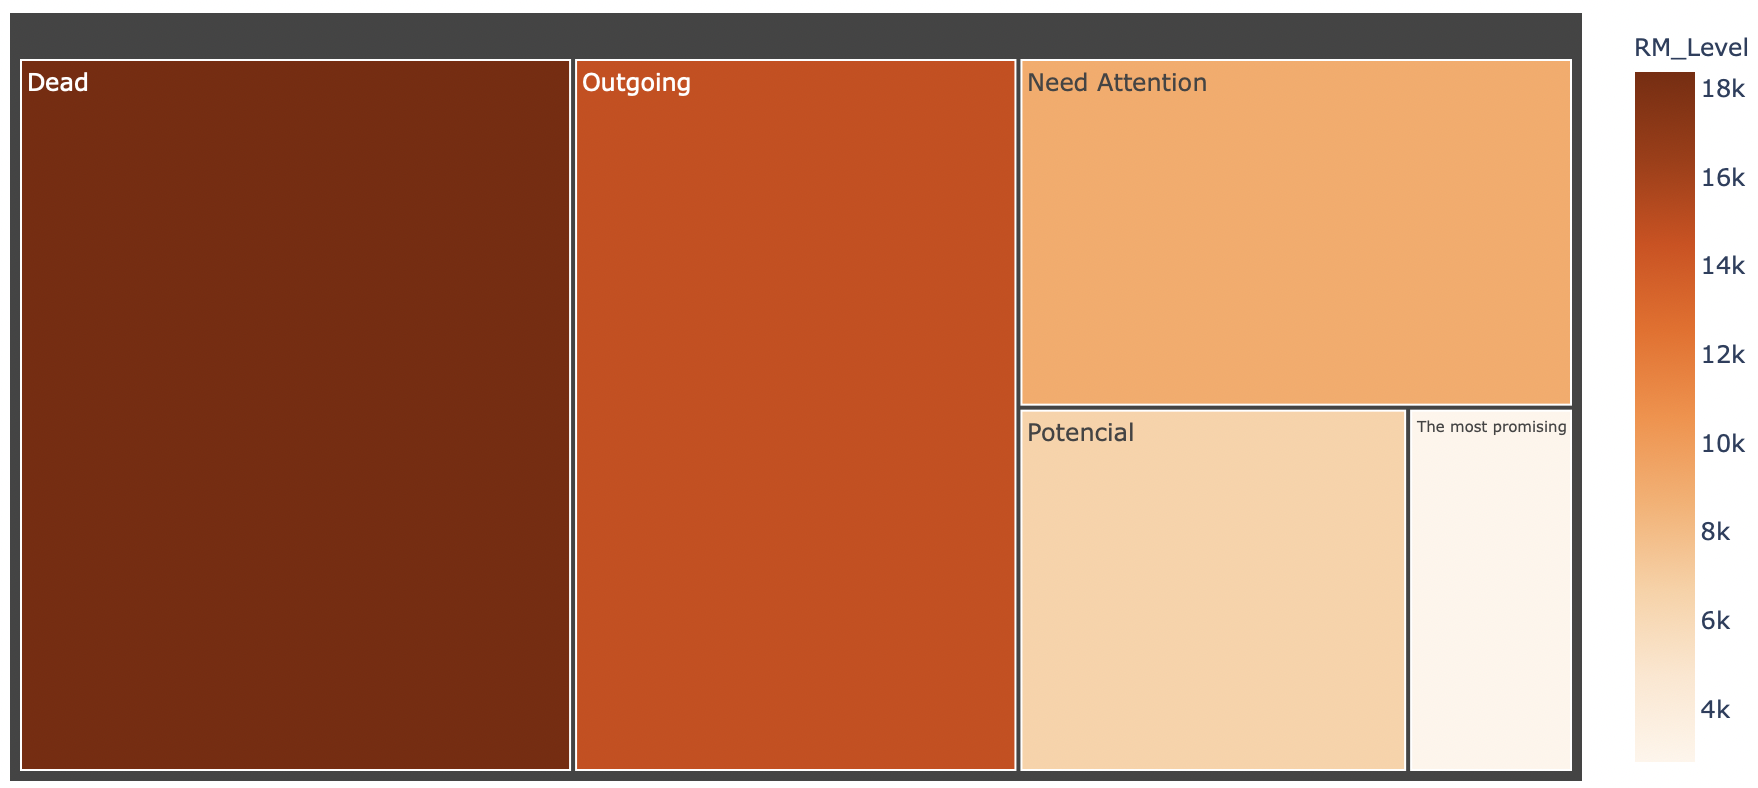

Вернемся к пользователям с 2+ заказами и рассмотрим их распределение по всем трем нашим факторам. Видим, что большая часть пользовалетей всего с 2 заказами:

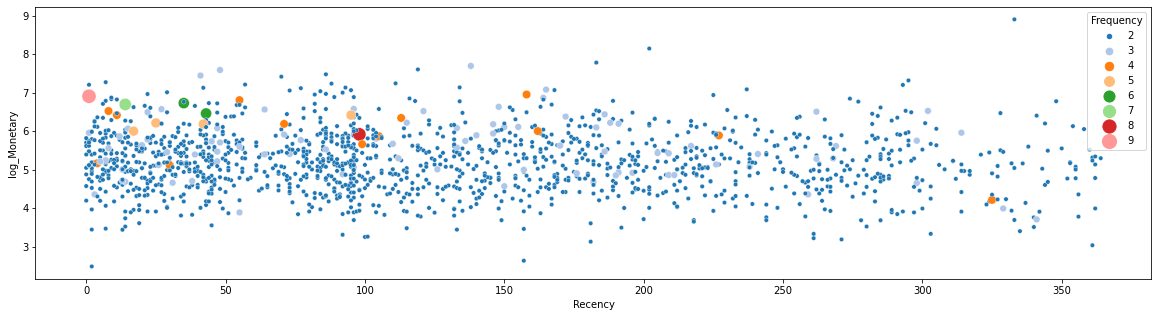

In [18]:
rfm2 = rfm.copy().query("Frequency > 1")

plt.figure(figsize=(20, 5))
sns.scatterplot(
    data=rfm2, x="Recency", y="log_Monetary", hue="Frequency", size="Frequency",
    sizes=(20, 200), legend="full", palette='tab20'
)

Определим ранги для них, создадим функции и применим их (функцию для активности берем из предыдушего шага для F = 1).

Разделение на ранги по количеству заказов составлено с учетом особенности данных (около 93% пользователей совершили 2 заказа):
- 2 orders
- 3+ orders

Разделение на ранги по последней активности (применимо к обоим сегментам и 1, и 2+):
- 5 - 0-30 days (0 to 1 month)
- 4 - 31-60 days (1 to 2 month)
- 3 - 61-90 days (2 to 3 month)
- 2 - 91-180 days (3 to 6 month)
- 1 - 181-365 days (6 to 12 month)

Разделение на ранги по сумме по заказам составлено на основе квантилей:
- 0 to 110 (~0-25 quantile)
- 110 to 180 (~25-50 quantile)
- 180 to 300 (~50-75 quantile)
- 300+

In [19]:
def f2_score(x):
    if x < 3:
        return 1
    else:
        return 2  

def m2_score(x):
    if x <= 110:
        return 1
    elif x <= 180:
        return 2
    elif x <= 300:
        return 3
    else:
        return 4   
    
rfm2['F2'] = rfm2['Frequency'].apply(lambda x: f2_score(x))
rfm2['M2'] = rfm2['Monetary'].apply(lambda x: m2_score(x))
rfm2['R2'] = rfm2['Recency'].apply(lambda x: r_score(x))

rfm2['RFM2'] = rfm2['R2'].astype(str) + rfm2['F2'].astype(str) + rfm2['M2'].astype(str)
rfm2['RFM2_Score'] = rfm2[['R2', 'F2', 'M2']].sum(axis=1)
rfm2.head()

,customer_unique_id,Recency,Frequency,Monetary,log_Monetary,F2,M2,R2,RFM2,RFM2_Score
56,004288347e5e88a27ded2bb23747066c,45,2,317.89,5.761705,1,4,4,414,9
169,00cc12a6d8b578b8ebd21ea4e2ae8b27,344,2,99.80,4.603168,1,1,1,111,3
235,011b4adcd54683b480c4d841250a987f,13,2,183.43,5.211833,1,3,5,513,9
264,013f4353d26bb05dc6652f1269458d8d,92,2,276.90,5.623656,1,3,2,213,6
281,015557c9912277312b9073947804a7ba,303,2,289.90,5.669536,1,3,1,113,5


На этапе выделения сегментов применим немного другой подход - попробуем определить сегменты по сумме рангов всех факторов:

- **Champions (10-11)** - наши лидеры, покупают часто и платят много.
- **Loyal (8-9)** - лояльные пользователи, наблюдается привычка к использованию продукта.
- **Need Attention (6-7)** - сегмент для более тщательного изучения, возможно, можем как-то удержать/заинтересовать пользователей.
- **Outgoing (5)** - уходящие клиенты, какую-то часть из которых возможно удастся вернуть, например, рассылкой пушей.
- **Dead (3-4)** - пользователи, которых скорее всего уже не получится вернуть, слишком давно сделана покупка и, вероятно, такие пользователи не нашли для себя ценность в продукте. БОльшая часть пользователей с такой оценкой, скорее всего, совершили всего 2 заказа.

In [20]:
def rfm_level2(df):
    if df['RFM2_Score'] >= 10:
        return 'Champions'
    elif ((df['RFM2_Score'] >= 8) and (df['RFM2_Score'] < 10)):
        return 'Loyal'
    elif ((df['RFM2_Score'] >= 7) and (df['RFM2_Score'] < 8)):
        return 'Need Attention'
    elif df['RFM2_Score'] == 5:
        return 'Outgoing'
    else:
        return 'Dead'

rfm2['RFM2_Level'] = rfm2.apply(rfm_level2, axis=1)
rfm2.head()

,customer_unique_id,Recency,Frequency,Monetary,log_Monetary,F2,M2,R2,RFM2,RFM2_Score,RFM2_Level
56,004288347e5e88a27ded2bb23747066c,45,2,317.89,5.761705,1,4,4,414,9,Loyal
169,00cc12a6d8b578b8ebd21ea4e2ae8b27,344,2,99.80,4.603168,1,1,1,111,3,Dead
235,011b4adcd54683b480c4d841250a987f,13,2,183.43,5.211833,1,3,5,513,9,Loyal
264,013f4353d26bb05dc6652f1269458d8d,92,2,276.90,5.623656,1,3,2,213,6,Dead
281,015557c9912277312b9073947804a7ba,303,2,289.90,5.669536,1,3,1,113,5,Outgoing


In [102]:
names2 = rfm2.RFM2_Level.value_counts().to_frame().index.to_list()
df2 = rfm2.RFM2_Level.value_counts().to_frame().reset_index()

# uncomment to find the details
# fig = px.treemap(df2, path=[names2], values='RFM2_Level', color='RFM2_Level', color_continuous_scale = 'oranges')
# fig.show()

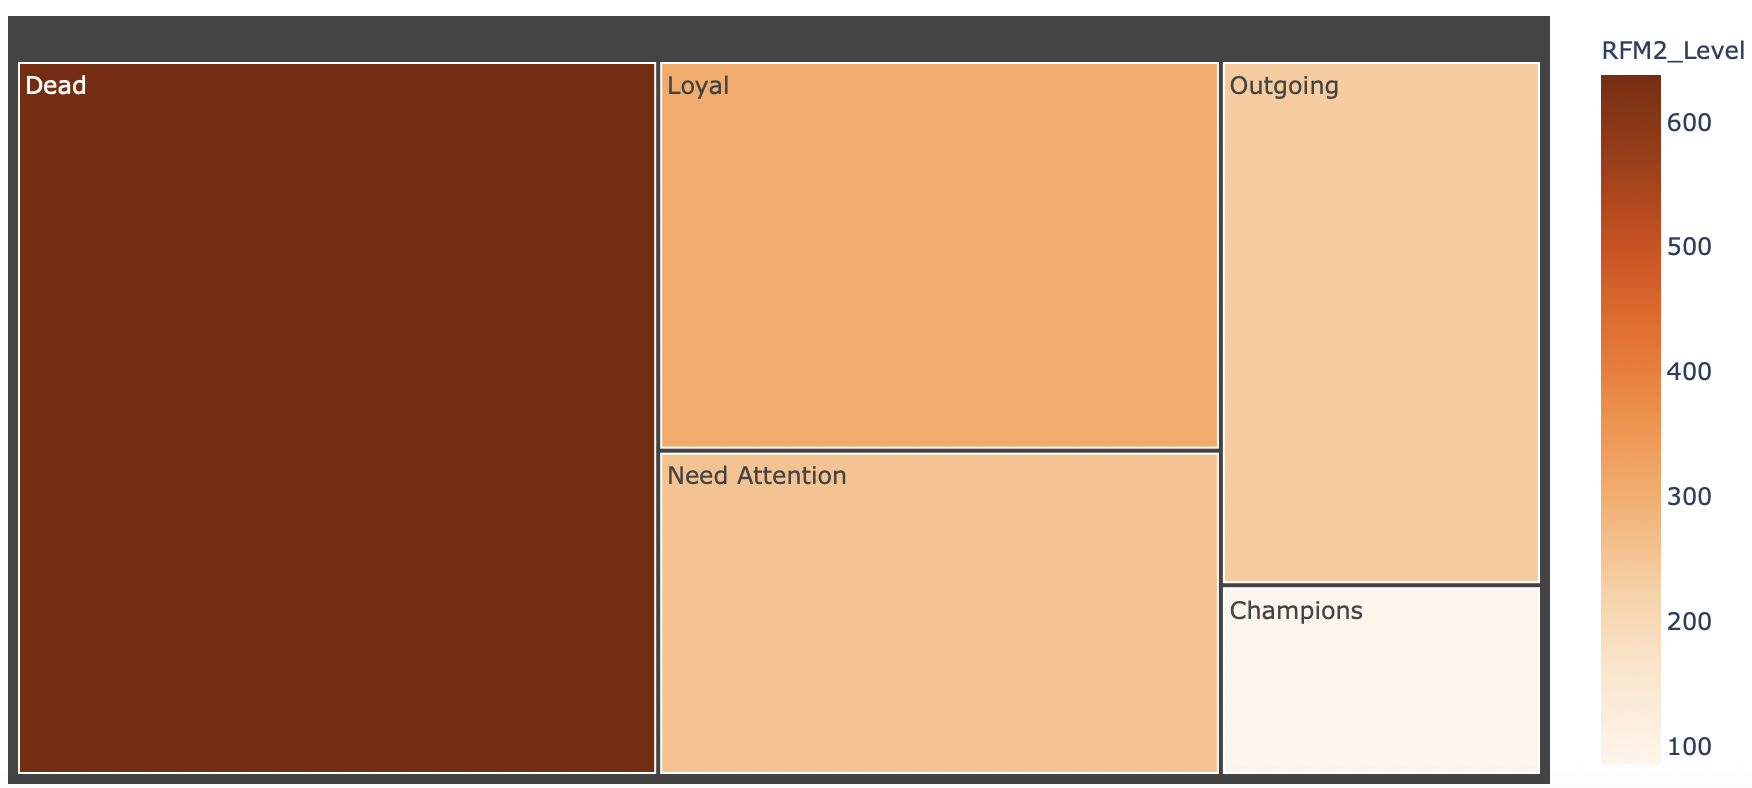

**Вывод:** исходя из полученных данных для пользователей с 2+ заказами, можно сказать, что в этом сегменте все хорошо, однако, процент таких пользователей от общего числа мал, что, скорее всего, нормально для такого типа сервисов/приложений. Упор нужно делать на пользователей с 1 заказом (особенно новоприбывших), повышая их лояльность, тем самым переводить их в следующий сегмент, где ситуация уже лучше. Также стоит проводить дальнейшие исследования и улучшать продукт и взаимодействие с ним, т.к. отток клиентов после первого использования колоссальный.